In [ ]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar dados usando Dask
def load_data(filepath, cols_to_use):
    return dd.read_csv(filepath, usecols=cols_to_use)

# Função para pré-processar os dados com Dask
def preprocess_data(df):
    return df

# Função para detectar e tratar anomalias
def detect_and_treat_anomalies(df):
    z_scores = ((df - df.mean()) / df.std()).abs()
    df = df[z_scores < 3].dropna()  # Remove valores com z-score > 3
    return df

# Aplicando o StandardScaler
def scale_data(df):
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para adicionar rótulo com base na pasta
def add_labels(df, label):
    df['label'] = label
    return df

# Função para balancear classes usando SMOTE
def balance_classes(df):
    smote = SMOTE()
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X_res, y_res = smote.fit_resample(X.compute(), y.compute())
    balanced_df = pd.concat([X_res, y_res], axis=1)
    return dd.from_pandas(balanced_df, npartitions=1)

# Processamento dos arquivos usando Dask
def process_files_in_folder_dask(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if not files:
        return dd.from_pandas(pd.DataFrame(), npartitions=1)
    df = dd.concat([load_data(file, cols_to_use) for file in files], axis=0)
    df = preprocess_data(df)
    df = detect_and_treat_anomalies(df)
    df = scale_data(df)
    df = df.map_partitions(lambda df_partition: add_labels(df_partition, label))
    return df

# Processamento paralelo usando Dask
def process_all_folders_dask(base_path, subfolders):
    folder_paths = [os.path.join(base_path, subfolder) for subfolder in subfolders if os.path.exists(os.path.join(base_path, subfolder))]
    results = []
    for folder_path in folder_paths:
        label = os.path.basename(folder_path)
        df = process_files_in_folder_dask(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                        'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                        'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], label)
        results.append(df)
    if results:
        final_df = dd.concat(results, axis=0)
        final_df = balance_classes(final_df)
        return final_df
    else:
        return dd.from_pandas(pd.DataFrame(), npartitions=1)

# Chamada principal
base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']
# Barra de progresso
with ProgressBar():
    final_df = process_all_folders_dask(base_path, subfolders).compute()

print("DataFrame com os dados pré-processados está pronto!")
print(final_df)


Mounted at /content/drive
[########################################] | 100% Completed | 7.30 s
[########################################] | 100% Completed | 9.48 s
[########################################] | 100% Completed | 9.73 s
[########################################] | 100% Completed | 7.72 s
[########################################] | 100% Completed | 7.94 s
[########################################] | 100% Completed | 8.73 s
[########################################] | 100% Completed | 8.38 s
[########################################] | 100% Completed | 10.41 s
[########################################] | 100% Completed | 10.77 s
[########################################] | 100% Completed | 10.53 s
[########################################] | 100% Completed | 86.55 s
[########################################] | 100% Completed | 84.09 s
[########################################] | 100% Completed | 155.01 ms
DataFrame com os dados pré-processados está pronto!
          v:X0014

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Preparando dados
X = final_df.drop('label', axis=1).values
y = final_df['label'].values

# Codificando rótulos para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertendo os dados para float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


In [ ]:
# Definindo modelo de RNA
def RNA_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)  # Ajuste da saída com a combinação do numero de classes
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Definindo e compilando modelo RNA
num_classes = len(np.unique(y_train))
model = RNA_model(X_train.shape[1:], num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Treinar o modelo usando GPU
with tf.device('/device:GPU:0'):
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)


Epoch 1/10
250050/250050 [==============================] - 1685s 7ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 2/10
250050/250050 [==============================] - 1676s 7ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 3/10
250050/250050 [==============================] - 1674s 7ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 7.9277e-04 - val_accuracy: 0.9998
Epoch 4/10
250050/250050 [==============================] - 1666s 7ms/step - loss: 0.0137 - accuracy: 0.9968 - val_loss: 7.2932e-04 - val_accuracy: 0.9998
Epoch 5/10
250050/250050 [==============================] - 1670s 7ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 6.4669e-04 - val_accuracy: 0.9999
Epoch 6/10
250050/250050 [==============================] - 1672s 7ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 4.3670e-04 - val_accuracy: 0.9999
Epoch 7/10
250050/250050 [==============================] - 1667s 7ms/step - l

62513/62513 [==============================] - 204s 3ms/step
Precisão: 0.9998930315487191
Recall: 0.9998930213957209
F1-Score: 0.9998930192422776


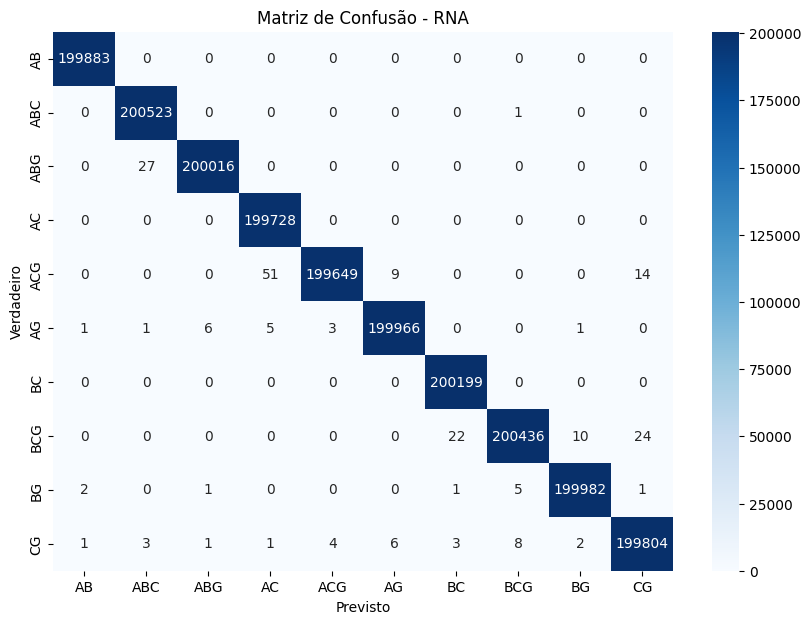

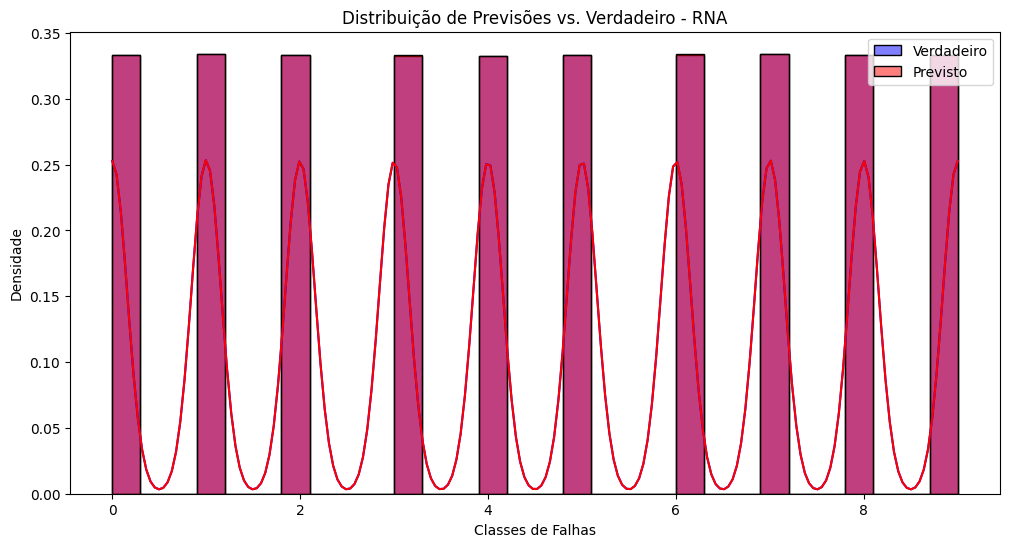

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculando métricas de desempenho
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão - RNA')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

# Função para plotar o histograma de previsões vs verdadeiro
def plot_predictions_vs_true(y_test, y_pred_classes):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_test, color='blue', label='Verdadeiro', kde=True, stat="density", bins=30)
    sns.histplot(y_pred_classes, color='red', label='Previsto', kde=True, stat="density", bins=30)
    plt.title('Distribuição de Previsões vs. Verdadeiro - RNA')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

# Plot matriz de confusão
labels = label_encoder.classes_
plot_confusion_matrix(conf_matrix, labels=labels)

# Plot histograma de previsões vs verdadeiro
plot_predictions_vs_true(y_test, y_pred_classes)
